In [1]:
import sys
sys.path.append('..')

import datetime
import json
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from ocf_blosc2 import Blosc2

from util.sunincidence import *

In [3]:
file = h5py.File('/data/climatehack/baked_data.h5', 'r')
file.keys()

with open("../indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        } for data_source, locations in json.load(f).items()
    }

pv = pd.read_pickle(f"/data/climatehack/pv.pkl")
df = pd.read_csv('/data/climatehack/official_dataset/pv/meta.csv')
df

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
...,...,...,...,...,...,...,...,...
24657,27063,51.41,-2.49,E01014398,185.0,35.0,4.00,2018-04-18
24658,27064,51.47,-0.59,E01016588,180.0,45.0,2.00,2018-04-18
24659,27065,51.36,-2.93,E01014817,125.0,37.0,4.00,2018-04-18
24660,27066,51.44,-2.85,E01014759,165.0,35.0,4.00,2018-04-18


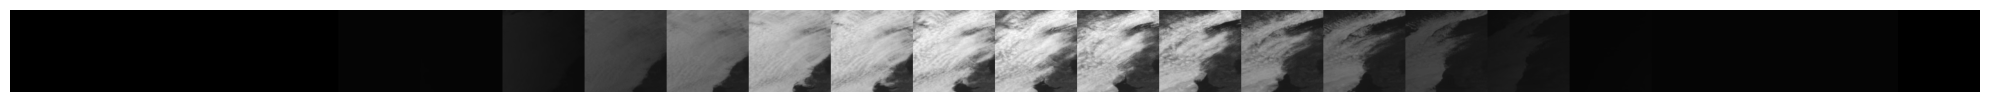

In [4]:
def show_nonhrv_vis_video_of_site(day: datetime.date, site_id, channel='VIS006'):
    nonhrv = xr.open_dataset(
        f"/data/climatehack/official_dataset/nonhrv/{day.year}/{day.month}.zarr.zip",
        engine="zarr",
        consolidated=True,
    )
    x, y = site_locations['nonhrv'][site_id]
    out = np.zeros((24 * 12, 128, 128))
    for hour in range(24):
        for i in range(12):
            try:
                d = nonhrv["data"].sel(time=datetime.datetime.combine(day, datetime.time(hour=hour, minute=5*i)), channel=channel)
                # out = d[:, y-64:y+64, x-64:x+64]
                out[12 * hour + i] = d[y-64:y+64, x-64:x+64]
            except KeyError:
                # print(f"Missing {datetime.datetime.combine(day, datetime.time(hour=hour, minute=5*i))}")
                pass

    plt.figure(figsize=(20, 4))
    plt.imshow(np.hstack(out[::12]), cmap='gray')
    plt.axis('off')
    plt.tight_layout()

show_nonhrv_vis_video_of_site(datetime.date(2021, 4, 3), 2607)

In [12]:
BI = file["bake_index"]
i = 3806474
print(BI[i]["time"])

1622278800


2021-05-29 {'latitude': 51.62, 'longitude': -4.03, 'elevation': 0, 'tilt': 31.0, 'azimuth': 226.0, 'zenith_limit': 90, 'zenith_filter': False, 'interval': 5}
{'latitude': 51.62, 'longitude': -4.03, 'elevation': 0, 'tilt': 31.0, 'azimuth': 226.0, 'zenith_limit': 90, 'zenith_filter': False, 'interval': 5}
Looping through solar position calcs...
Done!


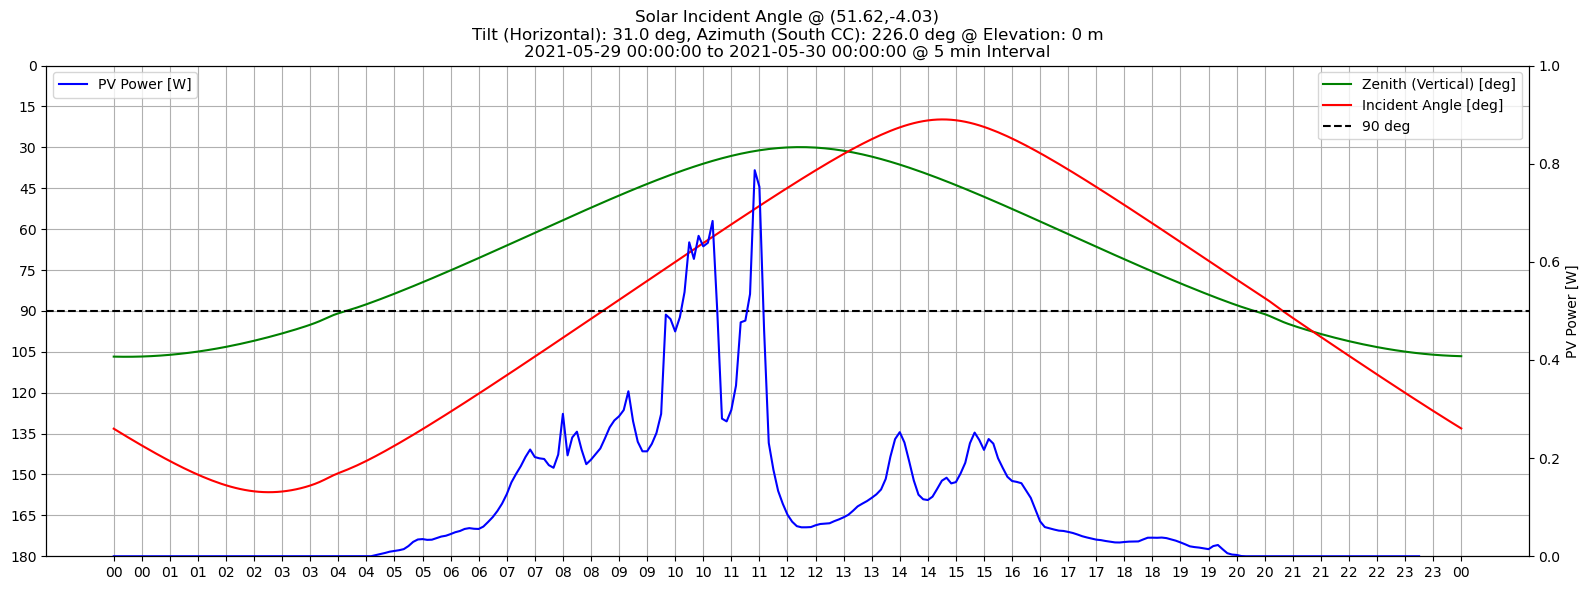

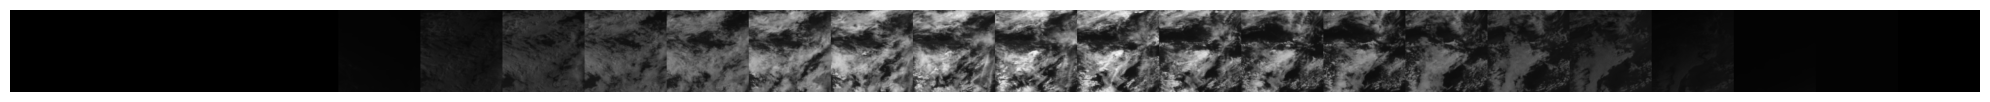

In [28]:
BI = file['bake_index']
# i = np.random.randint(0, len(BI))
i = 3806474
siteid, tstamp = BI[i]['site'], BI[i]['time']
dt = datetime.datetime.utcfromtimestamp(tstamp)
siteinfo = df[df['ss_id'] == siteid].iloc[0]
x, y = site_locations['nonhrv'][siteid]

proj = siteinfo2projectdata(siteinfo.latitude_rounded, siteinfo.longitude_rounded, siteinfo.orientation, siteinfo.tilt)

print(dt.date(), proj)
pv_data = pv.xs(slice(
    str(dt.date()),
    str(dt.date()),
)).xs(siteid).to_numpy().squeeze()

day_plot_with_pv(dt.date(), proj, pv_data)
show_nonhrv_vis_video_of_site(dt.date(), siteid)

[{'Datetime_UTC': datetime.datetime(2021, 5, 29, 9, 0),
  'Azimuth': 110.1665439030271,
  'Zenith': 47.684346854773686,
  'RightAscension': 66.18038032287852,
  'Declination': 21.66829343773751,
  'HourAngle': 311.659362855366,
  'IncidentAngle': 85.95525764145806},
 {'Datetime_UTC': datetime.datetime(2021, 5, 29, 9, 5),
  'Azimuth': 111.3996354858208,
  'Zenith': 46.95884770664463,
  'RightAscension': 66.18391778291785,
  'Declination': 21.66884561161826,
  'HourAngle': 312.90925605086704,
  'IncidentAngle': 84.79419333943713},
 {'Datetime_UTC': datetime.datetime(2021, 5, 29, 9, 10),
  'Azimuth': 112.65404871879457,
  'Zenith': 46.23947786377117,
  'RightAscension': 66.1874550627293,
  'Declination': 21.669397432953982,
  'HourAngle': 314.15914958740285,
  'IncidentAngle': 83.63312013866916},
 {'Datetime_UTC': datetime.datetime(2021, 5, 29, 9, 15),
  'Azimuth': 113.93076264229876,
  'Zenith': 45.52669370063503,
  'RightAscension': 66.1909921653317,
  'Declination': 21.669948895047014,

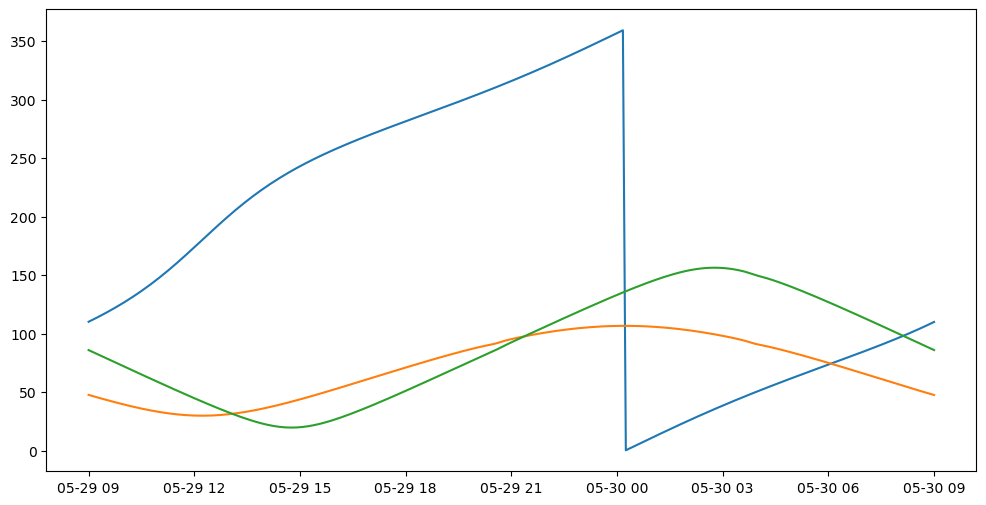

In [27]:
proj = siteinfo2projectdata(siteinfo.latitude_rounded, siteinfo.longitude_rounded, siteinfo.orientation, siteinfo.tilt)

dt = datetime.datetime.utcfromtimestamp(tstamp)
solar_data = loopSolarPositionByProject(start=dt, end=dt + datetime.timedelta(days=1), project_data=proj)
display(solar_data)

plt.figure(figsize=(12, 6))
plt.plot(list(map(lambda x: x['Datetime_UTC'], solar_data)), list(map(lambda x: x["Azimuth"], solar_data)))
plt.plot(list(map(lambda x: x['Datetime_UTC'], solar_data)), list(map(lambda x: x["Zenith"], solar_data)))
plt.plot(list(map(lambda x: x['Datetime_UTC'], solar_data)), list(map(lambda x: x["IncidentAngle"], solar_data)))

In [ ]:
siteinfo

In [ ]:
# find nearest solar panels to a given location based on latitude and longitude
def nearest_solar_panels(lat, lon, n=5):
    df['dist'] = np.sqrt((df['latitude_rounded'] - lat)**2 + (df['longitude_rounded'] - lon)**2)
    return df.sort_values('dist').head(n)

nearest_solar_panels(51.62, -4.03)

In [ ]:
BI = file['bake_index']
i = np.random.randint(0, len(BI))
siteid, tstamp = BI[i]['site'], BI[i]['time']
dt = datetime.datetime.utcfromtimestamp(tstamp)
siteinfo = df[df['ss_id'] == siteid].iloc[0]
x, y = site_locations['nonhrv'][siteid]

proj = siteinfo2projectdata(siteinfo.latitude_rounded, siteinfo.longitude_rounded, siteinfo.orientation, siteinfo.tilt)

print(dt.date(), proj)
pv_data = pv.xs(slice(
    str(dt.date()),
    str(dt.date()),
)).xs(siteid).to_numpy().squeeze()

day_plot_with_pv(dt.date(), proj, pv_data)
show_nonhrv_vis_video_of_site(dt.date(), siteid)

## My attempts to make it vectorized

In [ ]:
start_tstamp = datetime.datetime.strptime(p_start, "%Y-%m-%dT%H:%M").timestamp()
tstamps = np.array([start_tstamp + 5 * 60 * x for x in range(0, 256)])

In [ ]:
%%timeit
angles = np.zeros(len(tstamps))
for i, t in enumerate(tstamps):
    angles[i] = getSolarPosition(t, p_latitude_dd, p_longitude_dd, p_elevation_m, p_azimuth_deg, p_tilt_deg, p_zenith_filter, p_zenith_limit)['IncidentAngle']

In [ ]:
def getSolarPosition(t, lat, long, elev, azimuth, tilt):

	# Get solar position from lat/lng, elevation and datetime
	phi, theta_h, rasc, d, h = sunpos(t, lat, long, elev).T[:5]
	
	# Calculate tilt angle from vertical
	eta = 90 - tilt
	
	# Calculate surface-solar azimuth angle
	gamma = np.abs((phi - azimuth))

	# Calculate altitude angle
	beta = 90.0 - theta_h
	
	# Calculate incident angle to surface
	theta = np.rad2deg(np.arccos(
		np.cos(np.deg2rad(beta)) * np.cos(np.deg2rad(gamma)) * np.sin(np.deg2rad(eta))
	) + (
		np.sin(np.deg2rad(beta)) * np.cos(np.deg2rad(eta))
	))
	
	# Solar position datum
	# sp_datum = {
	# 	'Datetime_UTC': t,
	# 	'Azimuth': phi,
	# 	'Zenith': theta_h,
	# 	'RightAscension': rasc,
	# 	'Declination': d,
	# 	'HourAngle': h,
	# 	'IncidentAngle': theta
	# }
	
	return theta # sp_datum

In [ ]:
%%timeit
angles2 = getSolarPosition(tstamps, p_latitude_dd, p_longitude_dd, p_elevation_m, p_azimuth_deg, p_tilt_deg) # ['IncidentAngle']

In [ ]:
plt.plot(angles)
plt.plot(angles2)